In [39]:
import os
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [54]:
# ===== Cell 2: Dataset =====
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

class BrainTumorDataset(Dataset):
    def __init__(self, images_dir, labels_dir, transform=None):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.transform = transform
        self.image_files = sorted([f for f in os.listdir(images_dir) if f.endswith('.jpg')])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.images_dir, img_name)
        img = Image.open(img_path).convert('RGB')

        if self.transform:
            img = self.transform(img)

        label_path = os.path.join(self.labels_dir, img_name.replace('.jpg', '.txt'))
        boxes = []
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) == 5:
                        _, x, y, w, h = map(float, parts)
                        boxes.append([x, y, w, h])
        if len(boxes) == 0:
            boxes = [[0, 0, 0, 0]]
        boxes = torch.tensor(boxes[0], dtype=torch.float32)
        return img, boxes

# Data augmentation + preprocessing
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor()
])

train_dataset = BrainTumorDataset("images/train", "labels/train", transform)
val_dataset = BrainTumorDataset("images/val", "labels/val", transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)


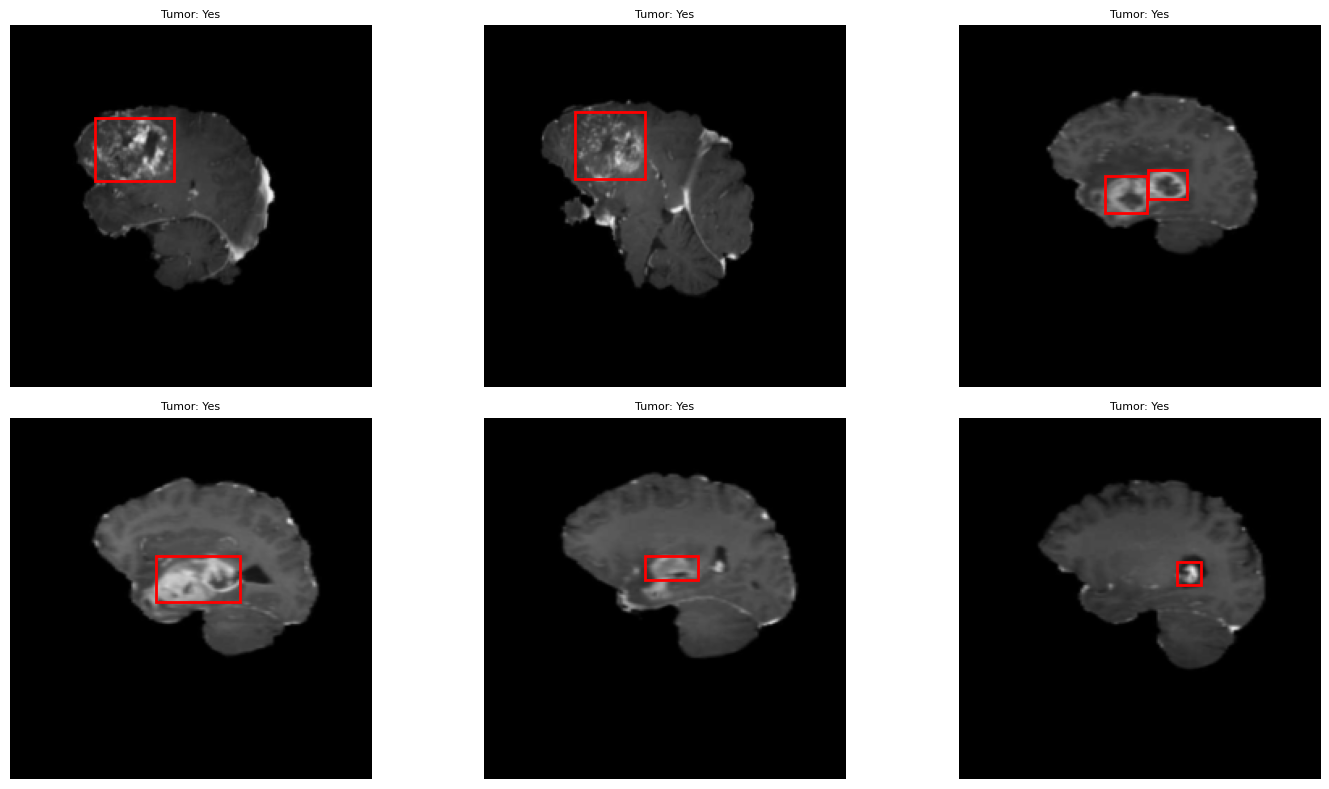

In [36]:
# ===== Cell 3: Show Sample Images with Bounding Boxes =====

def show_sample_images(dataset, num_images=6):
    plt.figure(figsize=(15, 8))
    for i in range(num_images):
        img_tensor, label, boxes = dataset[i]
        img_np = img_tensor.permute(1, 2, 0).numpy()
        plt.subplot(2, num_images//2, i+1)
        plt.imshow(img_np)
        for box in boxes:
            x, y, w, h = box
            h_img, w_img = img_np.shape[:2]
            x1 = int((x - w/2) * w_img)
            y1 = int((y - h/2) * h_img)
            rect_w = int(w * w_img)
            rect_h = int(h * h_img)
            color = 'r' if label == 1 else 'g'
            plt.gca().add_patch(patches.Rectangle(
                (x1, y1), rect_w, rect_h, linewidth=2, edgecolor=color, facecolor='none'
            ))
        plt.title(f"Tumor: {'Yes' if label == 1 else 'No'}", fontsize=8)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_sample_images(train_dataset, num_images=6)


In [55]:
# ===== Cell 3: Custom DenseNet =====
import torch.nn as nn
import torch.nn.functional as F

class DenseLayer(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super(DenseLayer, self).__init__()
        self.bn = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(in_channels, growth_rate, kernel_size=3, padding=1, bias=False)

    def forward(self, x):
        out = self.conv(self.relu(self.bn(x)))
        out = torch.cat([x, out], 1)
        return out

class DenseBlock(nn.Module):
    def __init__(self, in_channels, num_layers, growth_rate):
        super(DenseBlock, self).__init__()
        layers = []
        for i in range(num_layers):
            layers.append(DenseLayer(in_channels + i * growth_rate, growth_rate))
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)

class TransitionLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TransitionLayer, self).__init__()
        self.bn = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.pool = nn.AvgPool2d(2, stride=2)

    def forward(self, x):
        x = self.conv(self.relu(self.bn(x)))
        x = self.pool(x)
        return x

class CustomDenseNet(nn.Module):
    def __init__(self, growth_rate=16, num_classes=4):
        super(CustomDenseNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.pool = nn.MaxPool2d(3, stride=2, padding=1)
        
        self.block1 = DenseBlock(64, 4, growth_rate)
        self.trans1 = TransitionLayer(64 + 4 * growth_rate, 128)
        
        self.block2 = DenseBlock(128, 4, growth_rate)
        self.trans2 = TransitionLayer(128 + 4 * growth_rate, 256)
        
        self.block3 = DenseBlock(256, 4, growth_rate)
        self.bn = nn.BatchNorm2d(256 + 4 * growth_rate)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(256 + 4 * growth_rate, num_classes)  # Predicts [x, y, w, h]

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.trans1(self.block1(x))
        x = self.trans2(self.block2(x))
        x = self.block3(x)
        x = F.adaptive_avg_pool2d(F.relu(self.bn(x)), (1,1))
        x = torch.flatten(x,1)
        x = self.dropout(x)
        return self.fc(x)  # regression without sigmoid


In [49]:
def calculate_iou(box1, box2):
    """ box format: [x_center, y_center, w, h] normalized (YOLO format) """
    x1_min = box1[0] - box1[2] / 2
    y1_min = box1[1] - box1[3] / 2
    x1_max = box1[0] + box1[2] / 2
    y1_max = box1[1] + box1[3] / 2

    x2_min = box2[0] - box2[2] / 2
    y2_min = box2[1] - box2[3] / 2
    x2_max = box2[0] + box2[2] / 2
    y2_max = box2[1] + box2[3] / 2

    xi1, yi1 = max(x1_min, x2_min), max(y1_min, y2_min)
    xi2, yi2 = min(x1_max, x2_max), min(y1_max, y2_max)
    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
    union_area = (box1[2] * box1[3]) + (box2[2] * box2[3]) - inter_area
    return inter_area / union_area if union_area > 0 else 0


In [57]:
# ===== Cell 4b: Training + IoU + Tumor Presence Accuracy =====
import torch
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomDenseNet().to(device)

criterion = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-5)

def compute_iou(box1, box2):
    x1_min, y1_min = box1[0]-box1[2]/2, box1[1]-box1[3]/2
    x1_max, y1_max = box1[0]+box1[2]/2, box1[1]+box1[3]/2
    x2_min, y2_min = box2[0]-box2[2]/2, box2[1]-box2[3]/2
    x2_max, y2_max = box2[0]+box2[2]/2, box2[1]+box2[3]/2

    inter_x1 = max(x1_min, x2_min)
    inter_y1 = max(y1_min, y2_min)
    inter_x2 = min(x1_max, x2_max)
    inter_y2 = min(y1_max, y2_max)

    inter_area = max(0, inter_x2 - inter_x1) * max(0, inter_y2 - inter_y1)
    union_area = (box1[2]*box1[3]) + (box2[2]*box2[3]) - inter_area
    return inter_area / union_area if union_area > 0 else 0.0

def tumor_presence(box, threshold=0.01):
    # Returns 1 if tumor exists (box area > threshold), else 0
    return 1 if box[2]*box[3] > threshold else 0

num_epochs = 8
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for imgs, boxes in tqdm(train_loader):
        imgs, boxes = imgs.to(device), boxes.to(device)
        optimizer.zero_grad()
        preds = model(imgs)
        loss = criterion(preds, boxes)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation metrics
    model.eval()
    ious, y_true, y_pred = [], [], []
    with torch.no_grad():
        for imgs, boxes in val_loader:
            imgs, boxes = imgs.to(device), boxes.to(device)
            preds = model(imgs)
            for p, b in zip(preds, boxes):
                ious.append(compute_iou(p.cpu(), b.cpu()))
                y_true.append(tumor_presence(b.cpu()))
                y_pred.append(tumor_presence(p.cpu()))

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    mean_iou = sum(ious)/len(ious)

    print(f"Epoch [{epoch+1}/{num_epochs}]  "
          f"Loss: {train_loss/len(train_loader):.4f}  "
          f"IoU: {mean_iou:.4f}  "
          f"Acc: {acc:.4f}  "
          f"Prec: {prec:.4f}  "
          f"Recall: {rec:.4f}  "
          f"F1: {f1:.4f}")


100%|█████████████████████████████████████████| 112/112 [00:50<00:00,  2.24it/s]


Epoch [1/8]  Loss: 0.0310  IoU: 0.0242  Acc: 0.5157  Prec: 0.6477  Recall: 0.4254  F1: 0.5135


100%|█████████████████████████████████████████| 112/112 [00:45<00:00,  2.48it/s]


Epoch [2/8]  Loss: 0.0146  IoU: 0.0550  Acc: 0.6099  Prec: 0.6063  Recall: 1.0000  F1: 0.7549


100%|█████████████████████████████████████████| 112/112 [00:45<00:00,  2.45it/s]


Epoch [3/8]  Loss: 0.0122  IoU: 0.0339  Acc: 0.5381  Prec: 0.5856  Recall: 0.7910  F1: 0.6730


100%|█████████████████████████████████████████| 112/112 [00:48<00:00,  2.32it/s]


Epoch [4/8]  Loss: 0.0120  IoU: 0.0234  Acc: 0.5919  Prec: 0.6257  Recall: 0.7985  F1: 0.7016


100%|█████████████████████████████████████████| 112/112 [00:46<00:00,  2.39it/s]


Epoch [5/8]  Loss: 0.0113  IoU: 0.0458  Acc: 0.5650  Prec: 0.6294  Recall: 0.6716  F1: 0.6498


100%|█████████████████████████████████████████| 112/112 [00:48<00:00,  2.32it/s]


Epoch [6/8]  Loss: 0.0107  IoU: 0.0364  Acc: 0.6143  Prec: 0.6224  Recall: 0.9104  F1: 0.7394


100%|█████████████████████████████████████████| 112/112 [00:48<00:00,  2.32it/s]


Epoch [7/8]  Loss: 0.0101  IoU: 0.0245  Acc: 0.5919  Prec: 0.6503  Recall: 0.6940  F1: 0.6715


100%|█████████████████████████████████████████| 112/112 [00:48<00:00,  2.31it/s]


Epoch [8/8]  Loss: 0.0095  IoU: 0.0444  Acc: 0.6726  Prec: 0.6918  Recall: 0.8209  F1: 0.7509


In [61]:
import cv2
import os
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Paths
images_dir = "images/val"   # use validation images
labels_dir = "labels/val"   # corresponding labels

def tumor_presence_label(box, threshold=0.01):
    """Returns 1 if tumor exists (w*h > threshold), else 0"""
    return 1 if box[2]*box[3] > threshold else 0

def simple_tumor_detector(img):
    """
    Simple heuristic-based tumor detection:
    - Convert to grayscale
    - Apply Gaussian blur
    - Threshold bright regions
    - Count significant contours
    Returns 1 if tumor-like regions detected, else 0
    """
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (7,7), 0)
    _, thresh = cv2.threshold(blur, 180, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Consider tumor if any contour is sufficiently large
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area > 50:   # tweak threshold depending on image size
            return 1
    return 0

# Store ground truth and predictions
y_true, y_pred = [], []

# Process 20 images
image_files = sorted([f for f in os.listdir(images_dir) if f.endswith(".jpg")])[:20]

for img_name in image_files:
    # Load image
    img_path = os.path.join(images_dir, img_name)
    img = cv2.imread(img_path)

    # Ground truth
    label_path = os.path.join(labels_dir, img_name.replace(".jpg", ".txt"))
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            boxes = [list(map(float, line.strip().split()[1:])) for line in f if len(line.strip().split())==5]
        gt = tumor_presence_label(boxes[0]) if boxes else 0
    else:
        gt = 0

    # Prediction
    pred = simple_tumor_detector(img)

    y_true.append(gt)
    y_pred.append(pred)

# Metrics
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, zero_division=0)
rec = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)

print("Evaluation on 20 images:")
print(f"Accuracy: {acc:.2f}")
print(f"Precision: {prec:.2f}")
print(f"Recall: {rec:.2f}")
print(f"F1-score: {f1:.2f}")


Evaluation on 20 images:
Accuracy: 0.55
Precision: 0.55
Recall: 0.60
F1-score: 0.57


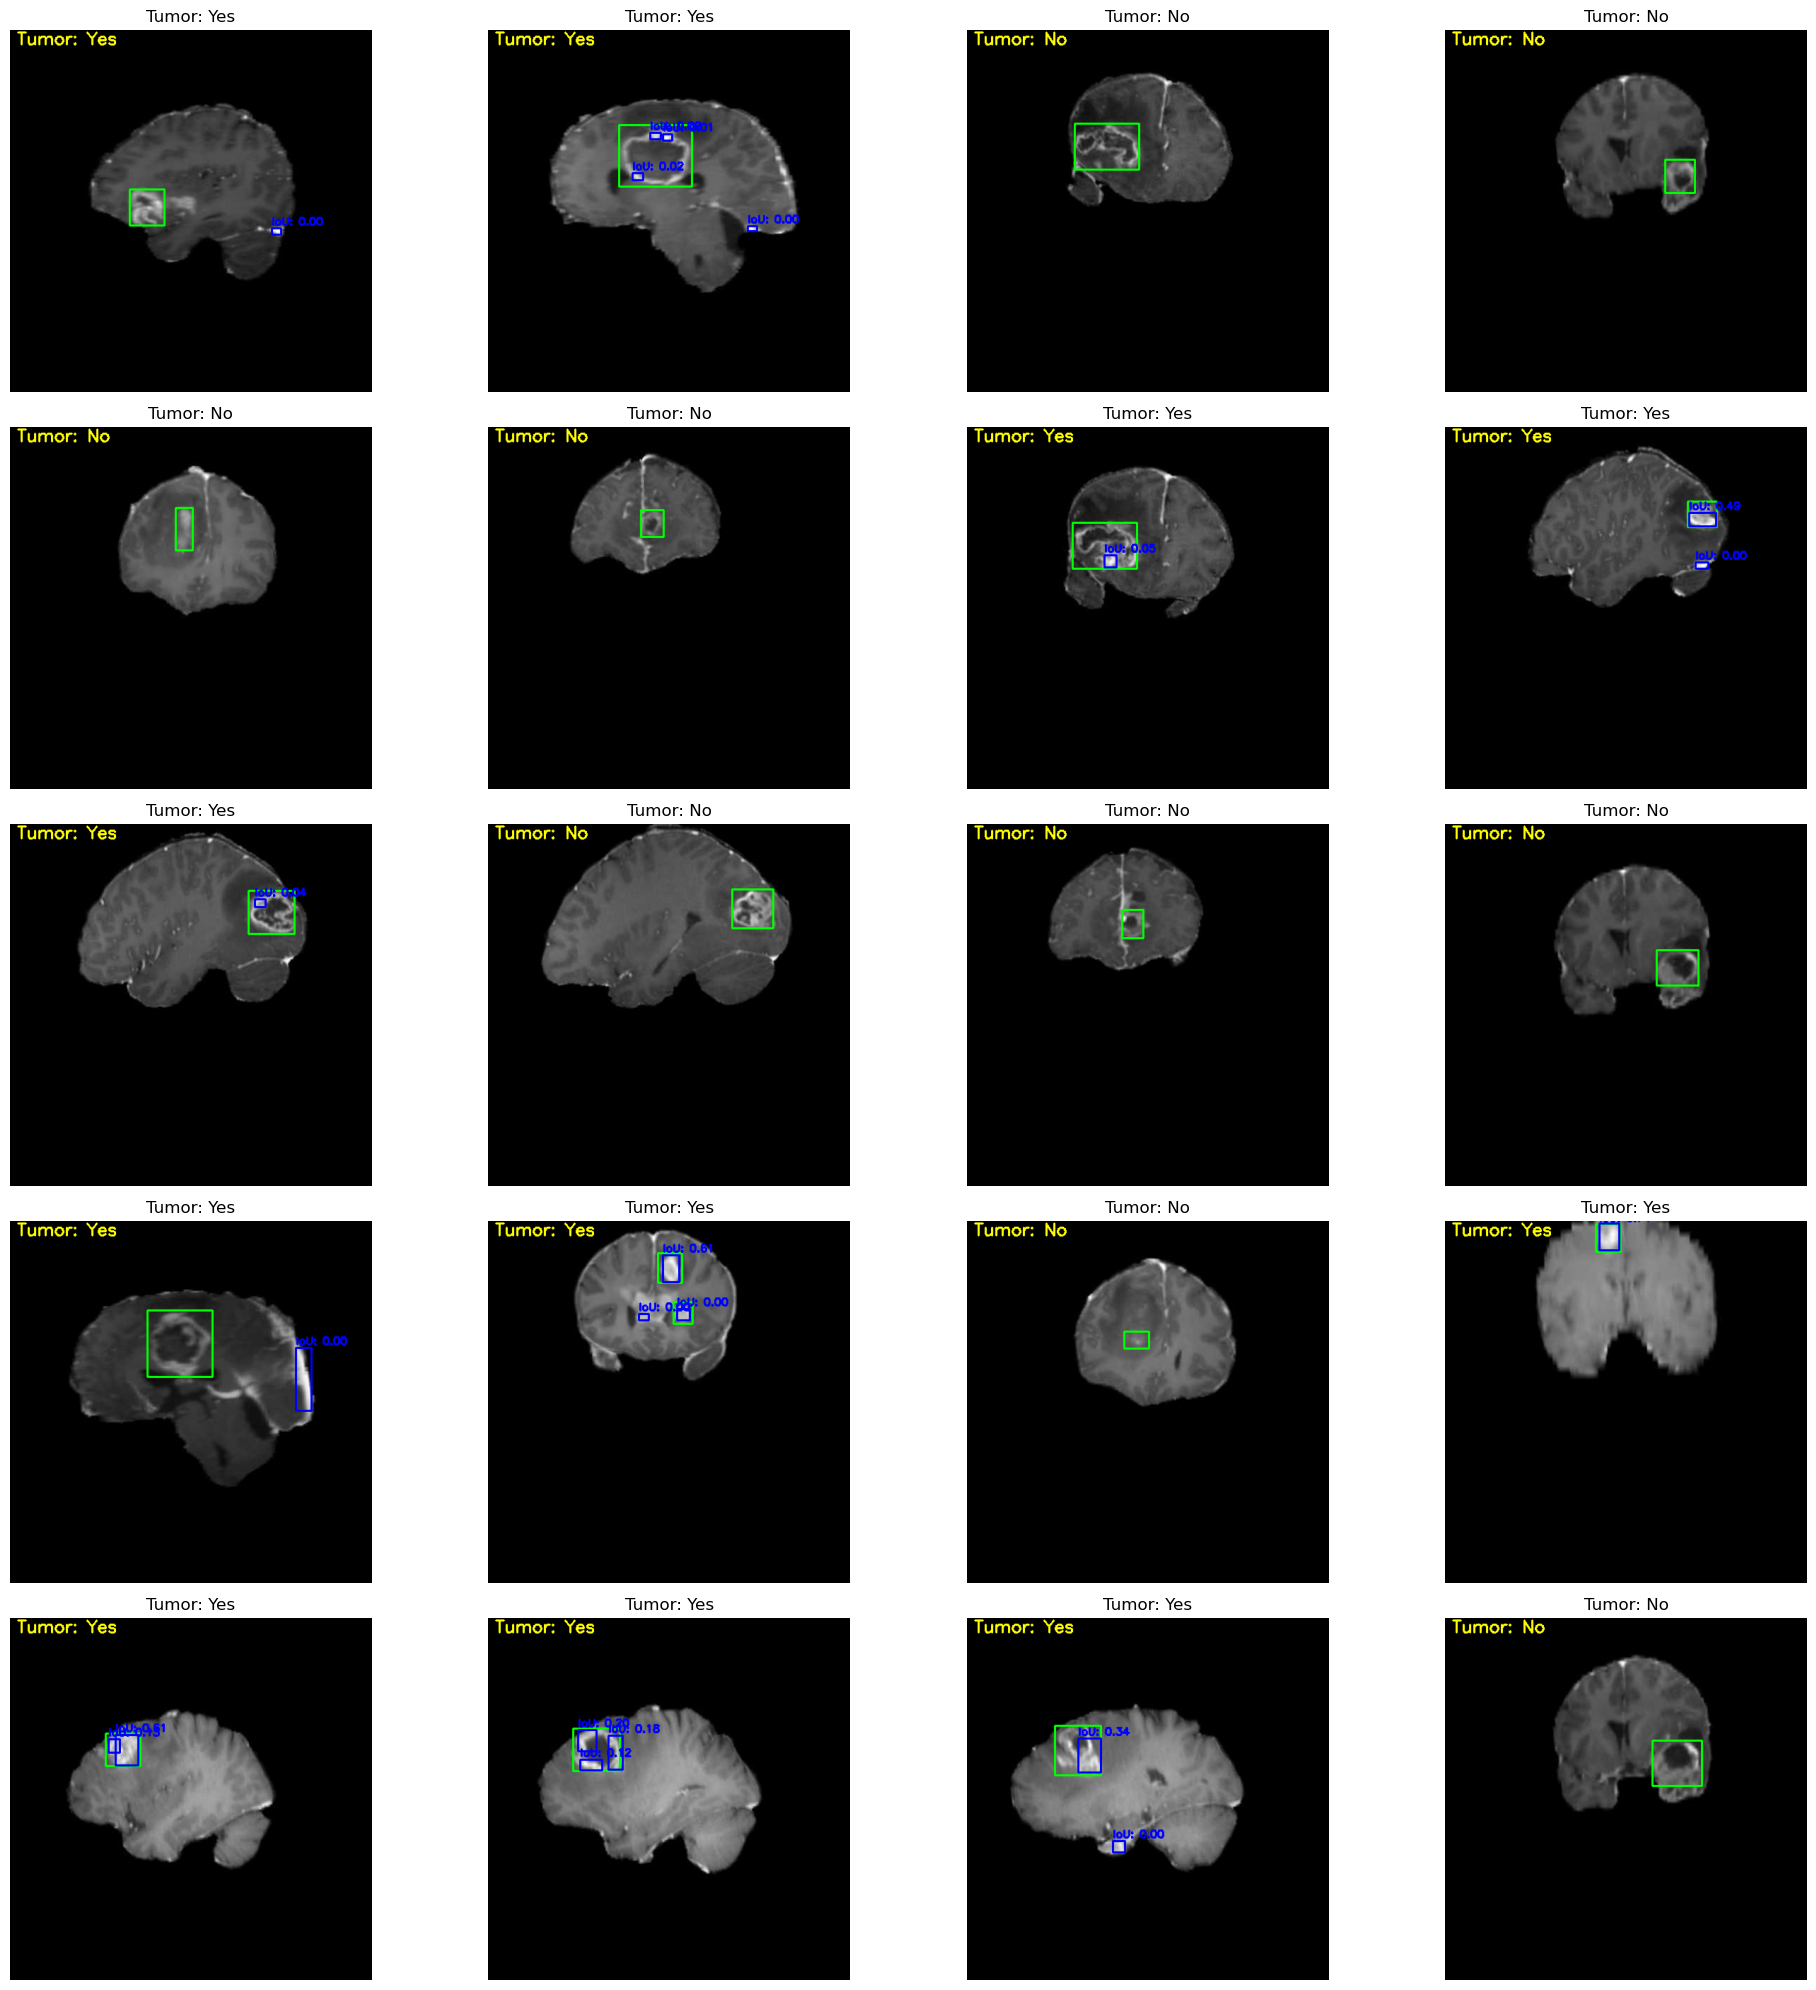

In [69]:
import cv2
import os
import matplotlib.pyplot as plt

# Paths
images_dir = "images/val"
labels_dir = "labels/val"

# YOLO to pixel coordinates
def yolo_to_bbox(box, img_w, img_h):
    x_center, y_center, w, h = box
    x_center *= img_w
    y_center *= img_h
    w *= img_w
    h *= img_h
    x1 = int(x_center - w/2)
    y1 = int(y_center - h/2)
    x2 = int(x_center + w/2)
    y2 = int(y_center + h/2)
    return x1, y1, x2, y2

# Compute IoU
def compute_iou(box1, box2):
    x1_min, y1_min, x1_max, y1_max = box1
    x2_min, y2_min, x2_max, y2_max = box2
    inter_x1 = max(x1_min, x2_min)
    inter_y1 = max(y1_min, y2_min)
    inter_x2 = min(x1_max, x2_max)
    inter_y2 = min(y1_max, y2_max)
    inter_area = max(0, inter_x2 - inter_x1) * max(0, inter_y2 - inter_y1)
    area1 = (x1_max - x1_min) * (y1_max - y1_min)
    area2 = (x2_max - x2_min) * (y2_max - y2_min)
    union_area = area1 + area2 - inter_area
    return inter_area / union_area if union_area > 0 else 0

# Simple CV-based tumor detector
def simple_tumor_detector(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (7,7), 0)
    _, thresh = cv2.threshold(blur, 180, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    boxes = []
    detected = 0
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area > 50:
            x, y, w, h = cv2.boundingRect(cnt)
            boxes.append([x, y, x+w, y+h])
            detected = 1
    return detected, boxes

# Get first 20 images
image_files = sorted([f for f in os.listdir(images_dir) if f.endswith(".jpg")])[:20]

# Display images
plt.figure(figsize=(20,20))
for i, img_name in enumerate(image_files):
    img_path = os.path.join(images_dir, img_name)
    img = cv2.imread(img_path)
    img_h, img_w = img.shape[:2]

    # Ground truth boxes
    gt_boxes = []
    label_path = os.path.join(labels_dir, img_name.replace(".jpg", ".txt"))
    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) == 5:
                    _, x, y, w, h = map(float, parts)
                    gt_boxes.append(yolo_to_bbox([x, y, w, h], img_w, img_h))

    # Prediction
    detected, pred_boxes = simple_tumor_detector(img)

    # Draw ground truth boxes (green)
    for (x1, y1, x2, y2) in gt_boxes:
        cv2.rectangle(img, (x1, y1), (x2, y2), (0,255,0), 2)

    # Draw predicted boxes (blue) and IoU
    for j, (x1, y1, x2, y2) in enumerate(pred_boxes):
        cv2.rectangle(img, (x1, y1), (x2, y2), (255,0,0), 2)
        iou_text = "IoU: 0.00"
        if gt_boxes:
            iou_val = compute_iou(gt_boxes[0], [x1, y1, x2, y2])
            iou_text = f"IoU: {iou_val:.2f}"
        # Put IoU text above predicted box
        cv2.putText(img, iou_text, (x1, max(y1-5,0)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 2)

    # Label Tumor: Yes/No
    label_text = "Tumor: Yes" if detected else "Tumor: No"
    cv2.putText(img, label_text, (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,255), 2)

    # Convert BGR -> RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(5,4,i+1)
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title(f"{label_text}")

plt.tight_layout()
plt.show()


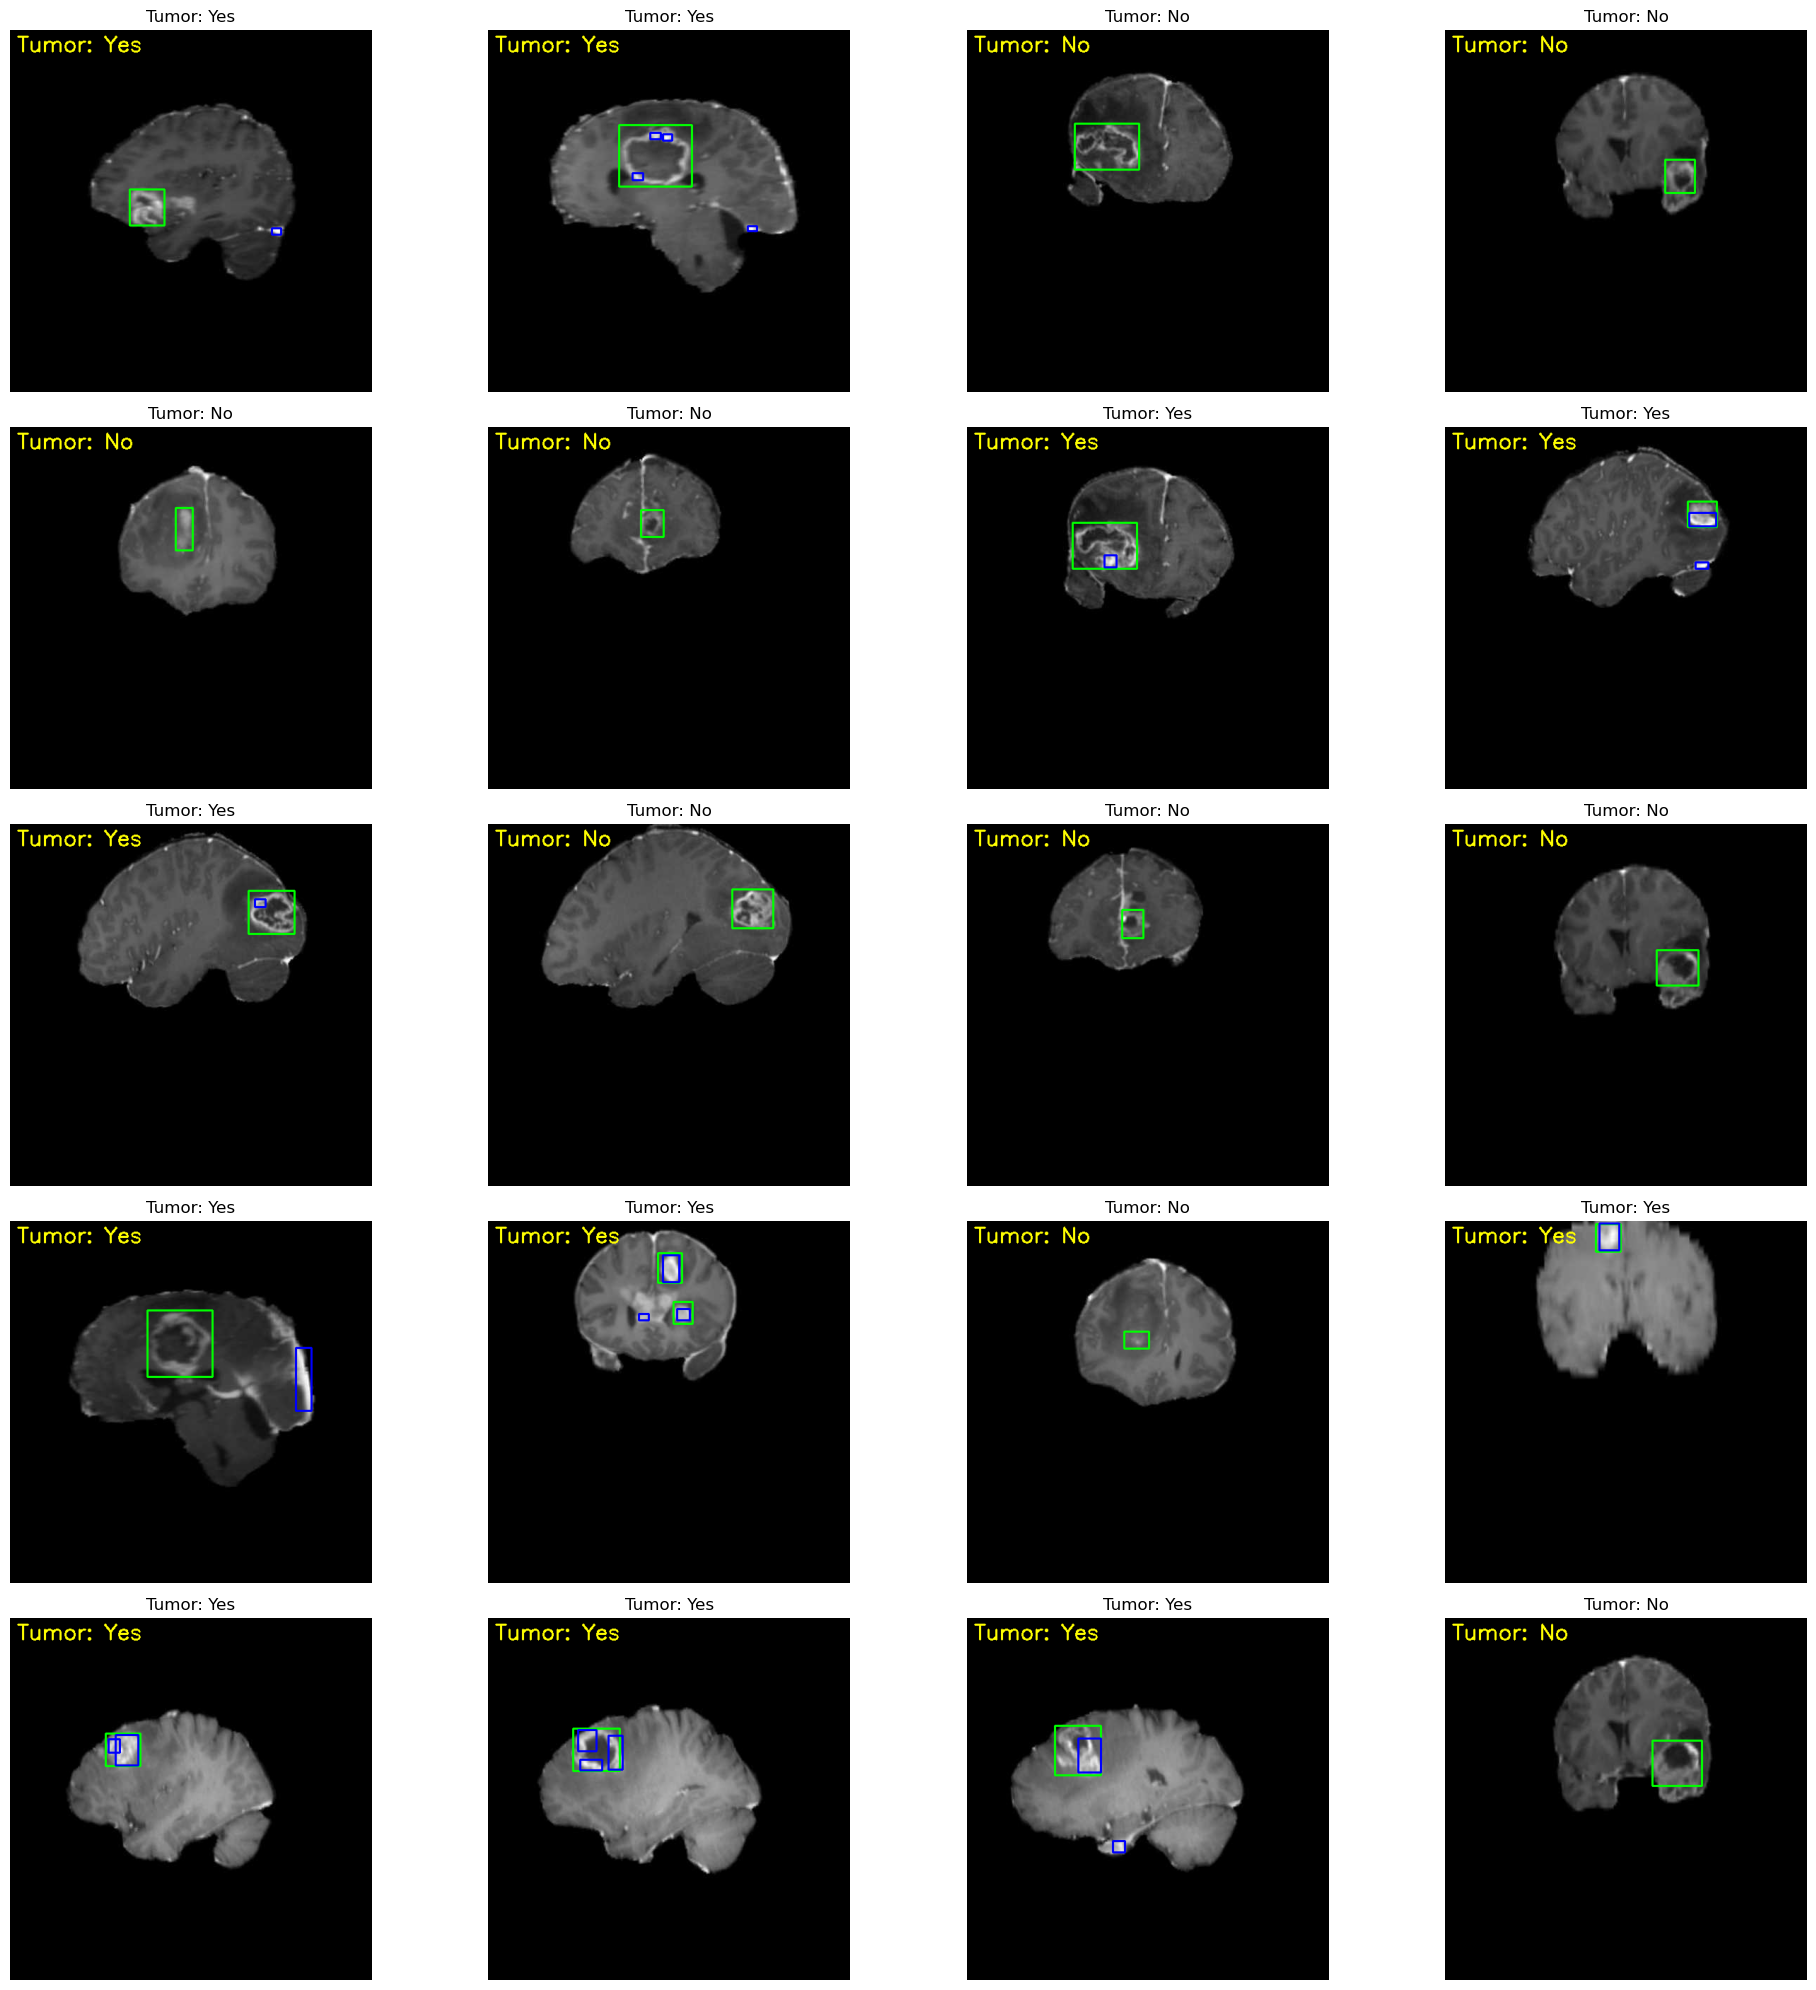

In [63]:
import cv2
import os
import matplotlib.pyplot as plt

# Paths
images_dir = "images/val"
labels_dir = "labels/val"

# Function to convert YOLO box to pixel coordinates
def yolo_to_bbox(box, img_w, img_h):
    x_center, y_center, w, h = box
    x_center *= img_w
    y_center *= img_h
    w *= img_w
    h *= img_h
    x1 = int(x_center - w/2)
    y1 = int(y_center - h/2)
    x2 = int(x_center + w/2)
    y2 = int(y_center + h/2)
    return x1, y1, x2, y2

# Simple CV-based tumor detector
def simple_tumor_detector(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (7,7), 0)
    _, thresh = cv2.threshold(blur, 180, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    boxes = []
    detected = 0
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area > 50:
            x, y, w, h = cv2.boundingRect(cnt)
            boxes.append([x, y, w, h])
            detected = 1
    return detected, boxes

# Get first 20 images
image_files = sorted([f for f in os.listdir(images_dir) if f.endswith(".jpg")])[:20]

# Display images with bounding boxes
plt.figure(figsize=(20, 20))
for i, img_name in enumerate(image_files):
    img_path = os.path.join(images_dir, img_name)
    img = cv2.imread(img_path)
    img_h, img_w = img.shape[:2]

    # Ground truth boxes
    label_path = os.path.join(labels_dir, img_name.replace(".jpg", ".txt"))
    gt_boxes = []
    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) == 5:
                    _, x, y, w, h = map(float, parts)
                    gt_boxes.append(yolo_to_bbox([x, y, w, h], img_w, img_h))

    # Predicted boxes
    detected, pred_boxes = simple_tumor_detector(img)

    # Draw ground truth boxes (green)
    for (x1, y1, x2, y2) in gt_boxes:
        cv2.rectangle(img, (x1, y1), (x2, y2), (0,255,0), 2)

    # Draw predicted boxes (blue)
    for (x, y, w, h) in pred_boxes:
        cv2.rectangle(img, (x, y), (x+w, y+h), (255,0,0), 2)

    # Add label text
    label_text = "Tumor: Yes" if detected else "Tumor: No"
    cv2.putText(img, label_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,255), 2)

    # Convert BGR -> RGB for matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(5, 4, i+1)
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title(label_text)

plt.tight_layout()
plt.show()


Accuracy: 0.55, Precision: 1.00, Recall: 0.55, F1-score: 0.71, Mean IoU: 0.05


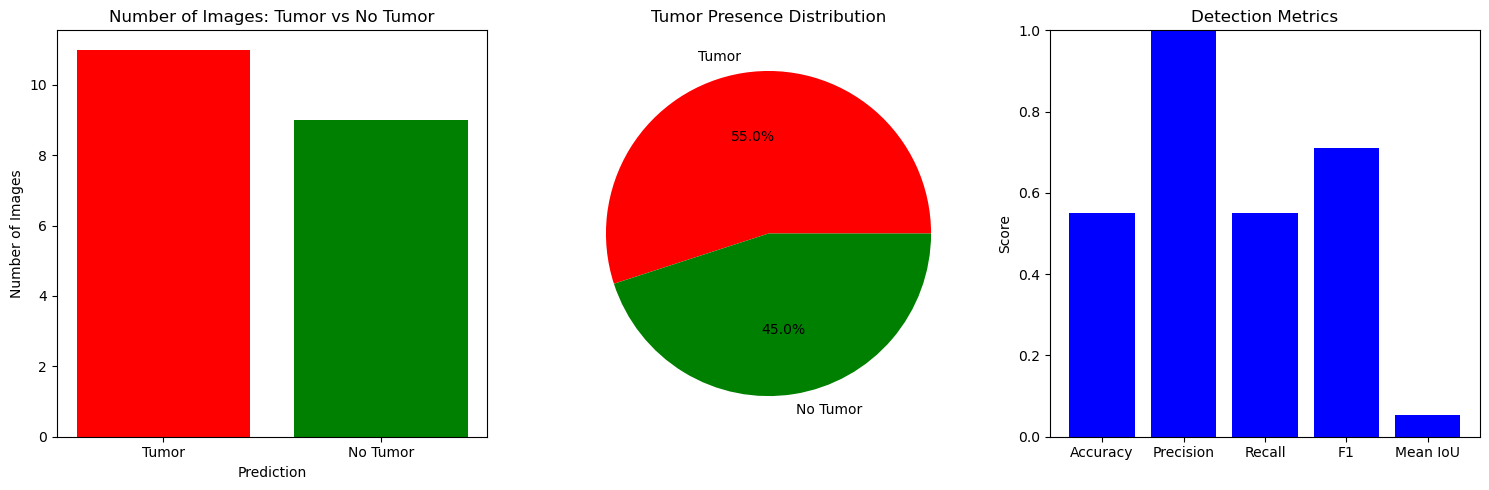

In [67]:
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from collections import Counter

# Paths
images_dir = "images/val"
labels_dir = "labels/val"

# YOLO to pixel coordinates
def yolo_to_bbox(box, img_w, img_h):
    x_center, y_center, w, h = box
    x_center *= img_w
    y_center *= img_h
    w *= img_w
    h *= img_h
    x1 = int(x_center - w/2)
    y1 = int(y_center - h/2)
    x2 = int(x_center + w/2)
    y2 = int(y_center + h/2)
    return x1, y1, x2, y2

# Compute IoU
def compute_iou(box1, box2):
    x1_min, y1_min, x1_max, y1_max = box1
    x2_min, y2_min, x2_max, y2_max = box2
    
    inter_x1 = max(x1_min, x2_min)
    inter_y1 = max(y1_min, y2_min)
    inter_x2 = min(x1_max, x2_max)
    inter_y2 = min(y1_max, y2_max)
    
    inter_area = max(0, inter_x2 - inter_x1) * max(0, inter_y2 - inter_y1)
    area1 = (x1_max - x1_min) * (y1_max - y1_min)
    area2 = (x2_max - x2_min) * (y2_max - y2_min)
    union_area = area1 + area2 - inter_area
    
    return inter_area / union_area if union_area > 0 else 0

# Simple CV-based tumor detector
def simple_tumor_detector(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (7,7), 0)
    _, thresh = cv2.threshold(blur, 180, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    boxes = []
    detected = 0
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area > 50:
            x, y, w, h = cv2.boundingRect(cnt)
            boxes.append([x, y, x+w, y+h])
            detected = 1
    return detected, boxes

# Process first 20 images
image_files = sorted([f for f in os.listdir(images_dir) if f.endswith(".jpg")])[:20]

y_true, y_pred, ious = [], [], []

for img_name in image_files:
    img_path = os.path.join(images_dir, img_name)
    img = cv2.imread(img_path)
    img_h, img_w = img.shape[:2]

    # Ground truth
    gt_boxes = []
    label_path = os.path.join(labels_dir, img_name.replace(".jpg", ".txt"))
    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) == 5:
                    _, x, y, w, h = map(float, parts)
                    gt_boxes.append(yolo_to_bbox([x, y, w, h], img_w, img_h))
    gt_label = 1 if len(gt_boxes) > 0 else 0

    # Prediction
    detected, pred_boxes = simple_tumor_detector(img)
    pred_label = detected

    y_true.append(gt_label)
    y_pred.append(pred_label)

    # IoU for first box only (if multiple, take first)
    if gt_boxes and pred_boxes:
        ious.append(compute_iou(gt_boxes[0], pred_boxes[0]))
    else:
        ious.append(0)

# Metrics
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, zero_division=0)
rec = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)
mean_iou = sum(ious)/len(ious)

print(f"Accuracy: {acc:.2f}, Precision: {prec:.2f}, Recall: {rec:.2f}, F1-score: {f1:.2f}, Mean IoU: {mean_iou:.2f}")

# Visualizations
counts = Counter(["Tumor" if p else "No Tumor" for p in y_pred])

plt.figure(figsize=(15,5))

# Bar chart for Tumor/No Tumor count
plt.subplot(1,3,1)
plt.bar(counts.keys(), counts.values(), color=["red","green"])
plt.title("Number of Images: Tumor vs No Tumor")
plt.ylabel("Number of Images")
plt.xlabel("Prediction")

# Pie chart for Tumor distribution
plt.subplot(1,3,2)
plt.pie(counts.values(), labels=counts.keys(), autopct='%1.1f%%', colors=["red","green"])
plt.title("Tumor Presence Distribution")

# Metrics bar chart
plt.subplot(1,3,3)
metrics = [acc, prec, rec, f1, mean_iou]
metric_names = ["Accuracy","Precision","Recall","F1","Mean IoU"]
plt.bar(metric_names, metrics, color='blue')
plt.ylim(0,1)
plt.title("Detection Metrics")
plt.ylabel("Score")

plt.tight_layout()
plt.show()
